<a href="https://colab.research.google.com/github/mihaijulien/Behavioral-Cloning/blob/master/Behavioral_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/mihaijulien/Behavioral-Cloning

Cloning into 'Behavioral-Cloning'...
remote: Enumerating objects: 11598, done.
remote: Total 11598 (delta 0), reused 0 (delta 0), pack-reused 11598
Receiving objects: 100% (11598/11598), 170.19 MiB | 11.26 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (11595/11595), done.


In [0]:
!ls Behavioral-Cloning/dataset

driving_log.csv  IMG


In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import ntpath
import pandas as pd
import numpy as np
import random

In [0]:
datadir = 'Behavioral-Cloning/dataset/'
columns = ['center','left','right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None) # set option to not limit the column width when displaying the head() next
data.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\Behavioral-Cloning\dataset\IMG\center_2020_06_05_16_06_16_735.jpg,D:\Behavioral-Cloning\dataset\IMG\left_2020_06_05_16_06_16_735.jpg,D:\Behavioral-Cloning\dataset\IMG\right_2020_06_05_16_06_16_735.jpg,0.0,0.0,0,9.144389e-06
1,D:\Behavioral-Cloning\dataset\IMG\center_2020_06_05_16_06_16_816.jpg,D:\Behavioral-Cloning\dataset\IMG\left_2020_06_05_16_06_16_816.jpg,D:\Behavioral-Cloning\dataset\IMG\right_2020_06_05_16_06_16_816.jpg,0.0,0.0,0,7.870705e-07
2,D:\Behavioral-Cloning\dataset\IMG\center_2020_06_05_16_06_16_907.jpg,D:\Behavioral-Cloning\dataset\IMG\left_2020_06_05_16_06_16_907.jpg,D:\Behavioral-Cloning\dataset\IMG\right_2020_06_05_16_06_16_907.jpg,0.0,0.0,0,7.281133e-06
3,D:\Behavioral-Cloning\dataset\IMG\center_2020_06_05_16_06_16_985.jpg,D:\Behavioral-Cloning\dataset\IMG\left_2020_06_05_16_06_16_985.jpg,D:\Behavioral-Cloning\dataset\IMG\right_2020_06_05_16_06_16_985.jpg,0.0,0.0,0,6.724605e-06
4,D:\Behavioral-Cloning\dataset\IMG\center_2020_06_05_16_06_17_057.jpg,D:\Behavioral-Cloning\dataset\IMG\left_2020_06_05_16_06_17_057.jpg,D:\Behavioral-Cloning\dataset\IMG\right_2020_06_05_16_06_17_057.jpg,0.0,0.0,0,8.078994e-06


In [0]:
def leaf_path(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(leaf_path)
data['right'] = data['right'].apply(leaf_path)
data['left'] = data['left'].apply(leaf_path)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_06_05_16_06_16_735.jpg,left_2020_06_05_16_06_16_735.jpg,right_2020_06_05_16_06_16_735.jpg,0.0,0.0,0,9.144389e-06
1,center_2020_06_05_16_06_16_816.jpg,left_2020_06_05_16_06_16_816.jpg,right_2020_06_05_16_06_16_816.jpg,0.0,0.0,0,7.870705e-07
2,center_2020_06_05_16_06_16_907.jpg,left_2020_06_05_16_06_16_907.jpg,right_2020_06_05_16_06_16_907.jpg,0.0,0.0,0,7.281133e-06
3,center_2020_06_05_16_06_16_985.jpg,left_2020_06_05_16_06_16_985.jpg,right_2020_06_05_16_06_16_985.jpg,0.0,0.0,0,6.724605e-06
4,center_2020_06_05_16_06_17_057.jpg,left_2020_06_05_16_06_17_057.jpg,right_2020_06_05_16_06_17_057.jpg,0.0,0.0,0,8.078994e-06


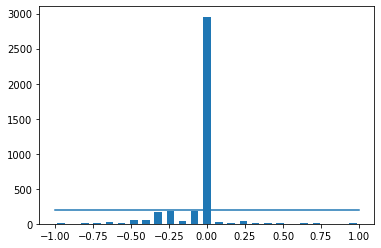

In [0]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 3864
removed: 2756
remaining: 1108


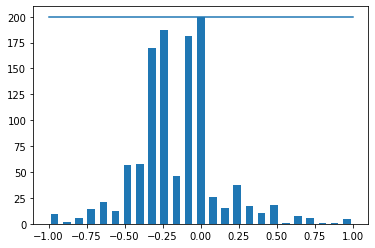

In [0]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
print(image_paths)
print(steerings)

center      center_2020_06_05_16_06_17_469.jpg
left          left_2020_06_05_16_06_17_469.jpg
right        right_2020_06_05_16_06_17_469.jpg
steering                                  -0.4
throttle                              0.334864
reverse                                      0
speed                                 0.274579
Name: 9, dtype: object
['Behavioral-Cloning/dataset//IMG/center_2020_06_05_16_06_17_383.jpg'
 'Behavioral-Cloning/dataset//IMG/left_2020_06_05_16_06_17_383.jpg'
 'Behavioral-Cloning/dataset//IMG/right_2020_06_05_16_06_17_383.jpg' ...
 'Behavioral-Cloning/dataset//IMG/center_2020_06_05_16_11_29_378.jpg'
 'Behavioral-Cloning/dataset//IMG/left_2020_06_05_16_11_29_378.jpg'
 'Behavioral-Cloning/dataset//IMG/right_2020_06_05_16_11_29_378.jpg']
[-0.2  -0.05 -0.35 ... -0.3  -0.15 -0.45]


Training samples: 2659 
 Test samples: 665


Text(0.5, 1.0, 'Test set')

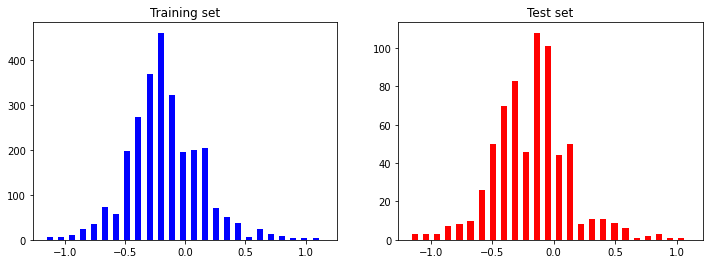

In [0]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings, test_size=0.2)
print('Training samples: {} \n Test samples: {}'.format(len(X_train), len(X_test)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_test, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Test set')

In [0]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135,:,:]  #crop out unnecessary background leaving only the road
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3),0)
  img = cv2.resize(img, (200, 66))
  return img

Text(0.5, 1.0, 'Preprocessed image')

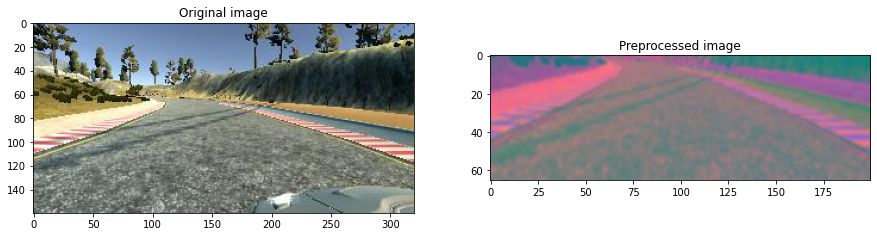

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fix, axis = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title("Original image")
axis[1].imshow(preprocessed_image)
axis[1].set_title("Preprocessed image")

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_test = np.array(list(map(img_preprocess, X_test)))

(2659, 66, 200, 3)


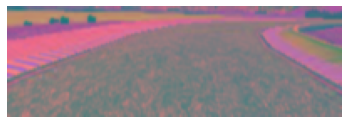

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [0]:
  def nvidia_model():
     
     model = Sequential()
     
     model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
     
     model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))
     model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
     model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
     model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
     model.add(Dropout(0.5))   
     model.add(Flatten())
     model.add(Dense(100, activation='relu'))
     model.add(Dropout(0.5))   
     model.add(Dense(50, activation='relu'))
     model.add(Dense(10, activation ='relu'))
     model.add(Dense(1))  
     optimizer= Adam(lr=1e-3)
     model.compile(loss='mse', optimizer=optimizer)
     
     return model

In [0]:
model = nvidia_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [0]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=100, verbose=1, shuffle=1)

Train on 2659 samples, validate on 665 samples
Epoch 1/30
2659/2659 [==============================] - 17s 7ms/step - loss: 0.1129 - val_loss: 0.1147
Epoch 2/30
2659/2659 [==============================] - 17s 6ms/step - loss: 0.1063 - val_loss: 0.1142
Epoch 3/30
2659/2659 [==============================] - 17s 6ms/step - loss: 0.1035 - val_loss: 0.1137
Epoch 4/30
2659/2659 [==============================] - 17s 6ms/step - loss: 0.0989 - val_loss: 0.0942
Epoch 5/30
2659/2659 [==============================] - 17s 6ms/step - loss: 0.0909 - val_loss: 0.0929
Epoch 6/30
2659/2659 [==============================] - 17s 7ms/step - loss: 0.0837 - val_loss: 0.0905
Epoch 7/30
2659/2659 [==============================] - 17s 6ms/step - loss: 0.0786 - val_loss: 0.0739
Epoch 8/30
2659/2659 [==============================] - 17s 6ms/step - loss: 0.0719 - val_loss: 0.0735
Epoch 9/30
2659/2659 [==============================] - 17s 6ms/step - loss: 0.0685 - val_loss: 0.0752
Epoch 10/30
2659/2659 [===

Text(0.5, 0, 'Epochs')

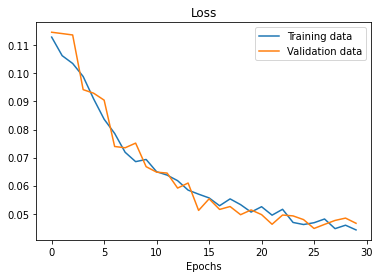

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training data', 'Validation data'])
plt.title('Loss')
plt.xlabel('Epochs')

In [0]:
model.save('model.h5')
from google.colab import files

files.download('model.h5')